<a href="https://colab.research.google.com/github/Yeongseok-Kim/PytorchClassReview/blob/master/gender_classificater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare dataset
코드를 작성한 colab Jupyter Notebook 환경은 12시간마다 런타임이 초기화되기 때문에, 코드를 실행하기 전에 사용할 데이터셋이 있는 드라이브와 마운트하는 작업이 필요합니다. 아래 코드에 사용된 데이터셋은 [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)의 처음 3만 개 이미지를 남성과 여성으로 분류하고 그 중 20%에 해당하는 6천 개 이미지를 테스트셋으로 제한 데이터셋입니다.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/gender_classification.zip'

In [0]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from PIL import Image



class MyDataset(Dataset):
    def __init__(self, female_dir, male_dir):
        self.female_list = [female_dir + file_name for file_name in os.listdir(female_dir)]
        self.male_list = [male_dir + file_name for file_name in os.listdir(male_dir)]
        self.transforms = transforms.Compose([transforms.CenterCrop((128, 128)),
                                              transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
    
    def __len__(self):
        return len(self.female_list + self.male_list)
    
    def __getitem__(self, index):
        female_len = len(self.female_list)
        if index < female_len:
            img = Image.open(self.female_list[index])
            label = torch.zeros(1)
        else:
            img = Image.open(self.male_list[index - female_len])
            label = torch.ones(1)
        img = self.transforms(img)
        return img, label

In [0]:
import torch.nn as nn



class Classificater(nn.Module):
    def __init__(self):
        super(Classificater, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        
        self.fc = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#Training
학습을 언제까지 시켜야 하는지, 고민을 많이 했습니다. 주기적으로 train cost와 test cost를 비교하여 test cost가 낮아지는 경향을 보이면 학습을 멈추는 것도 고려하였으나, Local minimum에서 학습이 멈추는 경우를 염두에 두어, 시간과 자원이 허용하는 한에서 충분한 학습을 하는 편이 좋다고 판단하였습니다.

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader



if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 64
    train_data = MyDataset('/content/train_set/female/', '/content/train_set/male/')
    train_set = DataLoader(train_data, batch_size, True)

    test_batch = 64
    test_data = MyDataset('/content/test_set/female/', '/content/test_set/male/')
    test_set = DataLoader(test_data, test_batch, True)

    learning_rate = 0.0002
    training_epochs = 20

    net = Classificater().to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(net.parameters(), learning_rate)

    print('Learning started. it takes sometime.')

    for epoch in range(1, training_epochs + 1):
        for img, label in train_set:
            batch_size = img.size(0)

            img = img.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            hypothesis = net(img)
            cost = criterion(hypothesis, label)

            cost.backward()
            optimizer.step()

            print("epoch %d train cost : %f" % (epoch, cost.item()))

        print('epoch %d is over.' % epoch)

        if epoch % 10 == 0:
            with torch.no_grad():
                for img, label in test_set:
                    test_batch = img.size(0)

                    img = img.to(device)
                    label = label.to(device)

                    prediction = net(img)
                    cost = criterion(prediction, label)

                    print("epoch %d test cost : %f" % (epoch, cost.item()))
            
            torch.save(net.state_dict(), './gender_classificater_epoch_%d.pth' % epoch)
    
    print('Learning Finished.')

#Result

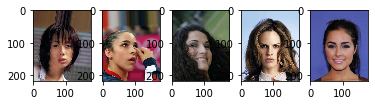

TypeError: ignored

In [24]:
import random
from matplotlib import pyplot as plt
import matplotlib.image as mpimg



transforms = transforms.Compose([transforms.CenterCrop((128, 128)),
                                 transforms.Resize((64, 64)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    net = Classificater().to(device)

    load_net = './gender_classificater_epoch_20.pth'
    net.load_state_dict(torch.load(load_net))

    with torch.no_grad():
        female_dir = '/content/test_set/female/'
        female_list = [female_dir + file_name for file_name in os.listdir(female_dir)]
        random.shuffle(female_list)
        imgs = female_list[:5]

        fig = plt.figure()

        ax = []
        for i in range(5):
            ax.append(fig.add_subplot(1, 5, i + 1))
        
        for i in range(5):
            show_img = mpimg.imread(imgs[i])
            ax[i].imshow(show_img)
        
        plt.show()

        for img in imgs:
            test_img = Image.open(img)
            test_img = transforms(test_img)

            prediction = net(img)

            print(prediction)